In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import shap
from lime.lime_text import LimeTextExplainer
import string

In [3]:
data = pd.read_csv('C:/Users/sachu/Desktop/DB/final_ats_scores1.csv')

# Basic data inspection
print(data.head())
print(data.info())


         ID                                         Resume_str  \
0  18176523           SENIOR INFORMATION TECHNOLOGY MANAGER...   
1  18176523           SENIOR INFORMATION TECHNOLOGY MANAGER...   
2  18176523           SENIOR INFORMATION TECHNOLOGY MANAGER...   
3  18176523           SENIOR INFORMATION TECHNOLOGY MANAGER...   
4  18176523           SENIOR INFORMATION TECHNOLOGY MANAGER...   

                 Category      job_id  \
0  INFORMATION-TECHNOLOGY  3905367422   
1  INFORMATION-TECHNOLOGY  3887888322   
2  INFORMATION-TECHNOLOGY  3905243094   
3  INFORMATION-TECHNOLOGY  3905323971   
4  INFORMATION-TECHNOLOGY  3903830212   

                                         title  \
0                           Trademark Attorney   
1  Delivery Driver / CDL A required / Seasonal   
2                             Senior Recruiter   
3                Order Fulfillment Coordinator   
4       Medical Assistant Urgent Care Per Diem   

                                         description  A

        text_length   word_count
count   8181.000000  8181.000000
mean    6496.330400   832.786823
std     2559.447496   336.818887
min     1888.000000   255.000000
25%     5216.000000   641.000000
50%     5904.000000   750.000000
75%     7611.000000  1008.000000
max    17242.000000  2302.000000


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


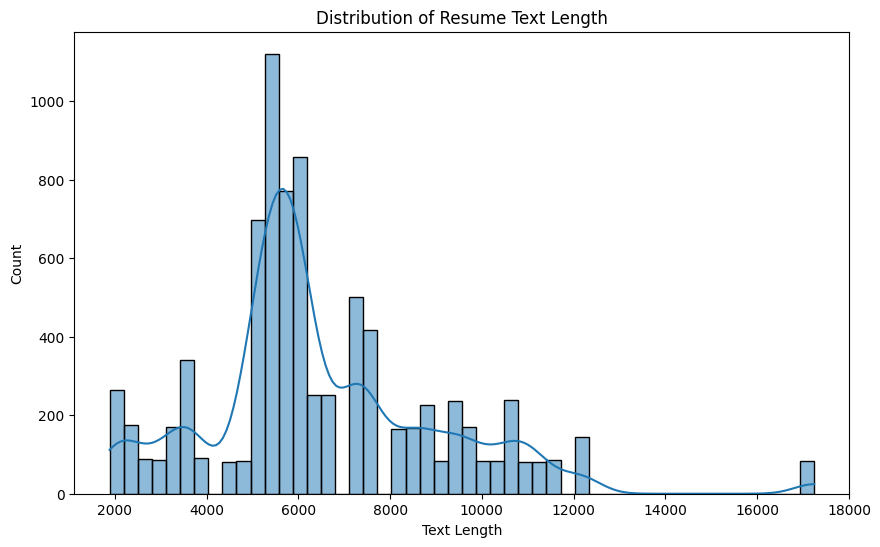

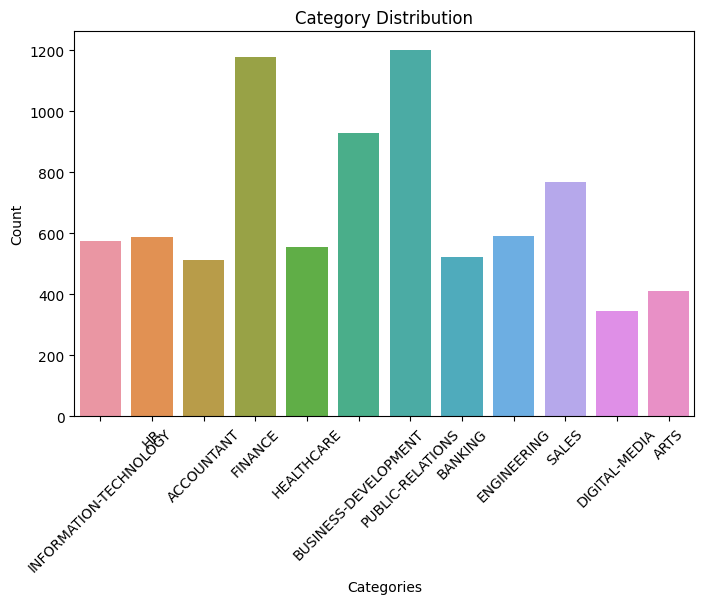

In [4]:
# Text Statistics
data['text_length'] = data['Resume_str'].apply(lambda x: len(str(x)))
data['word_count'] = data['Resume_str'].apply(lambda x: len(str(x).split()))
print(data[['text_length', 'word_count']].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Resume Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Category', data=data)
plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [5]:


# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

# Advanced text cleaning function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning to 'Resume_str' and 'description' columns
data['Cleaned_Resume'] = data['Resume_str'].apply(clean_text)
data['Cleaned_Description'] = data['description'].apply(clean_text)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len_resume = 1500  # Define maximum length of sequences for resume
max_len_description = 1500  # adjust as needed

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Resume_str'] + ' ' + data['description'])

X_resume = tokenizer.texts_to_sequences(data['Resume_str'])
X_description = tokenizer.texts_to_sequences(data['description'])

X_resume = pad_sequences(X_resume, maxlen=max_len_resume)
X_description = pad_sequences(X_description, maxlen=max_len_description)

X_combined = np.concatenate([X_resume, X_description], axis=-1)
y = data['ATS_Score'].values



In [7]:
vocab_size = len(tokenizer.word_index) + 1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [9]:
import shutil
import os

# Define the directory where the tuner files are saved
tuner_dir = 'my_dir/gru_ats'

# Check if the directory exists
if os.path.exists(tuner_dir):
    # Delete the directory and all its contents
    shutil.rmtree(tuner_dir)
    print(f"Cleared cache and deleted directory: {tuner_dir}")
else:
    print(f"Directory does not exist: {tuner_dir}")


Directory does not exist: my_dir/gru_ats


In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
import keras_tuner as kt

# Sample data preparation (assuming you have your data as dataframes X_train and y_train)

max_len = 1500  # Adjust based on your data preprocessing
vocab_size = 20000  # Example value, replace with your actual vocab size

# Define a function to build the GRU model with hyperparameter tuning
def build_gru_model(hp):
    input_seq = Input(shape=(2 * max_len,), dtype='int32')

    # Embedding layer
    embedding_dim = hp.Choice('embedding_dim', values=[50, 100])
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2 * max_len)(input_seq)

    # Tuning the number of units in the GRU layers
    units_1 = hp.Int('units_1', min_value=32, max_value=64, step=32)

    # GRU Layer
    gru_output = Bidirectional(GRU(units_1, return_sequences=False))(x)

    # Tuning the number of units in the Dense layers
    dense_units = hp.Int('dense_units', min_value=32, max_value=64, step=32)

    x = Dense(dense_units, activation='relu')(gru_output)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='linear')(x)  # Use 'linear' for regression tasks

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])), loss='mean_squared_error', metrics=['mae'])
    
    return model

# Define a Keras Tuner tuner object
tuner_gru = kt.Hyperband(
    build_gru_model,
    objective='val_mae',
    max_epochs=3,
    factor=3,
    directory='my_dir',
    project_name='gru_ats'
)

# Use only 10% of the original training data for hyperparameter search
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Run the hyperparameter search
tuner_gru.search(X_train_small, y_train_small, epochs=3, validation_split=0.2)

# Get the optimal hyperparameters
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters for GRU: {best_hps_gru.values}")

# Build the best model with optimal hyperparameters
model_gru_best = tuner_gru.hypermodel.build(best_hps_gru)

# Train the model on the entire dataset
history_gru_best = model_gru_best.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Dummy data for evaluation
# Replace X_test and y_test with your actual test data
X_test = np.random.randint(0, vocab_size, size=(200, 2 * max_len))
y_test = np.random.rand(200)

# Evaluate the model
loss_gru_best, mae_gru_best = model_gru_best.evaluate(X_test, y_test)
print(f"Best Bidirectional GRU - Test Loss: {loss_gru_best}, Test MAE: {mae_gru_best}")


Trial 6 Complete [00h 00m 50s]
val_mae: 46.539947509765625

Best val_mae So Far: 14.908382415771484
Total elapsed time: 00h 03m 36s
Best hyperparameters for GRU: {'embedding_dim': 50, 'units_1': 64, 'dense_units': 32, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 1, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0000'}
Epoch 1/10
164/164 [==============================] - 220s 1s/step - loss: 749.2808 - mae: 21.6845 - val_loss: 307.4756 - val_mae: 14.9070
Epoch 2/10
164/164 [==============================] - 312s 2s/step - loss: 362.1028 - mae: 15.5971 - val_loss: 302.6043 - val_mae: 14.4529
Epoch 3/10
164/164 [==============================] - 327s 2s/step - loss: 298.0518 - mae: 13.8877 - val_loss: 194.9183 - val_mae: 11.0819
Epoch 4/10
164/164 [==============================] - 329s 2s/step - loss: 229.7562 - mae: 12.1381 - val_loss: 168.3943 - val_mae: 10.5354
Epoch 5/10
164/164 [==============================] - 318s 2s/step - loss: 196.8682 - mae: 11

In [11]:
# Build the best model with optimal hyperparameters
model_gru_best = tuner_gru.hypermodel.build(best_hps_gru)

# Train the model
history_gru_best = model_gru_best.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model
loss_gru_best, mae_gru_best = model_gru_best.evaluate(X_test, y_test)
print(f"Best Bidirectional GRU - Test Loss: {loss_gru_best}, Test MAE: {mae_gru_best}")

Epoch 1/10
164/164 [==============================] - 364s 2s/step - loss: 917.1678 - mae: 24.4611 - val_loss: 307.3250 - val_mae: 14.8909
Epoch 2/10
164/164 [==============================] - 333s 2s/step - loss: 369.1051 - mae: 15.6922 - val_loss: 305.4588 - val_mae: 14.7382
Epoch 3/10
164/164 [==============================] - 353s 2s/step - loss: 350.8151 - mae: 15.2900 - val_loss: 215.4918 - val_mae: 12.1437
Epoch 4/10
164/164 [==============================] - 353s 2s/step - loss: 240.3563 - mae: 12.2897 - val_loss: 168.2457 - val_mae: 10.4036
Epoch 5/10
164/164 [==============================] - 352s 2s/step - loss: 206.7831 - mae: 11.3438 - val_loss: 138.9679 - val_mae: 9.0167
Epoch 6/10
164/164 [==============================] - 349s 2s/step - loss: 181.1702 - mae: 10.6044 - val_loss: 129.2982 - val_mae: 8.8201
Epoch 7/10
164/164 [==============================] - 353s 2s/step - loss: 167.4967 - mae: 10.1080 - val_loss: 120.8301 - val_mae: 8.5528
Epoch 8/10
164/164 [==========

In [12]:
# Predict ATS scores on the test set
y_pred = model_gru_best.predict(X_test)

7/7 [==============================] - 3s 385ms/step


7/7 [==============================] - 3s 379ms/step - loss: 1701.9254 - mae: 40.5885
Test Loss: 1701.9254150390625, Test MAE: 40.588478088378906


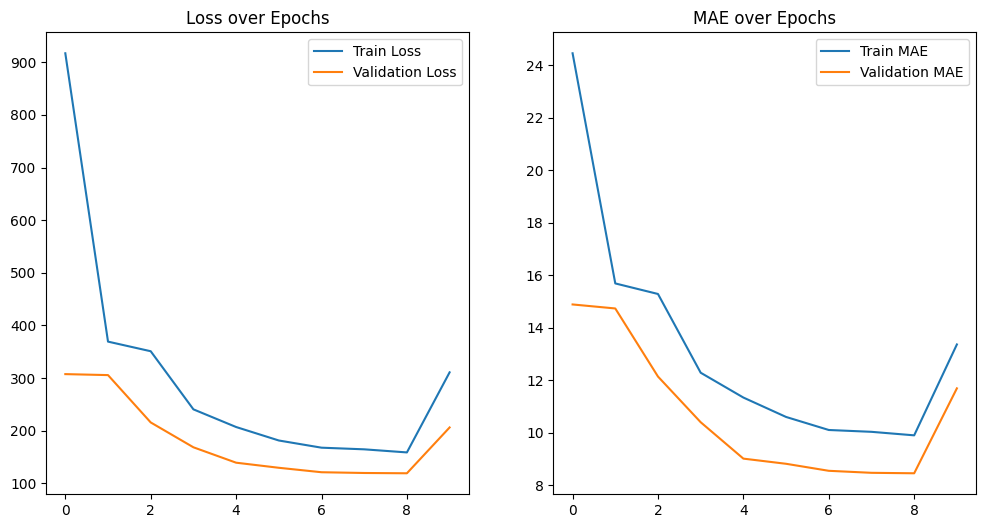

In [13]:
# Evaluate the model
loss, mae = model_gru_best.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru_best.history['loss'], label='Train Loss')
plt.plot(history_gru_best.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru_best.history['mae'], label='Train MAE')
plt.plot(history_gru_best.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.show()


In [17]:
import shap

# explainer = shap.DeepExplainer(model_gru_best, X_train[:100])
# shap_values = explainer.shap_values(X_test[:100])

# # Plot summary
# shap.summary_plot(shap_values, X_test[:100], feature_names=['resume', 'job_desc', 'cosine_similarity', 'resume_length', 'job_desc_length'])




# Define the model prediction function
def model_predict(data):
    return model_gru_best.predict(data)

# Ensure X_train and X_test are numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Use a sample of the training data to initialize the explainer
explainer = shap.KernelExplainer(model_predict, X_train[:100])

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test[:100])

# Plot summary
shap.summary_plot(shap_values, X_test[:100], feature_names=['resume', 'job_desc', 'cosine_similarity', 'resume_length', 'job_desc_length'])


4/4 [==============================] - 2s 407ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

  209/25150 [..............................] - ETA: 6:40:12